In [1]:
!python3 -m pip install 'pandas[performance, parquet]>=2.0' matplotlib seaborn rdflib

In [2]:
import rdflib
import pandas as pd
import numpy as np

In [86]:
def result_to_df(qr) -> pd.DataFrame:
    d = pd.DataFrame(qr.bindings, dtype="string")
    d.columns = [str(x) for x in d.columns]
    for c in d.columns:
        d[c] = d[c].astype('str')
    return d

In [87]:
g = rdflib.Graph()
g.parse("building.ttl")

<Graph identifier=N6885705dd408450d8404ccdcd18ea870 (<class 'rdflib.graph.Graph'>)>

In [88]:
query = """
SELECT ?equip ?hsp ?csp ?sensor WHERE {
    ?equip brick:hasPoint ?csp, ?hsp, ?sensor .
    ?csp rdf:type brick:Occupied_Cooling_Temperature_Setpoint .
    ?hsp rdf:type brick:Occupied_Heating_Temperature_Setpoint .
    ?sensor rdf:type brick:Supply_Air_Temperature_Sensor .
    }
"""

In [89]:
metadata = result_to_df(g.query(query))
metadata

,csp,equip,hsp,sensor
0,http://brick.mines.edu/anon/:BuildingName_01:F...,http://brick.mines.edu/anon/FCU051,http://brick.mines.edu/anon/occ_htg_sp_cac4f3aa,http://brick.mines.edu/anon/:BuildingName_01:F...
1,http://brick.mines.edu/anon/:BuildingName_01:F...,http://brick.mines.edu/anon/FCU180,http://brick.mines.edu/anon/:BuildingName_01:F...,http://brick.mines.edu/anon/:BuildingName_01:F...
2,http://brick.mines.edu/anon/:BuildingName_01:F...,http://brick.mines.edu/anon/FCU191,http://brick.mines.edu/anon/:BuildingName_01:F...,http://brick.mines.edu/anon/:BuildingName_01:F...
3,http://brick.mines.edu/anon/:BuildingName_01:F...,http://brick.mines.edu/anon/FCU201,http://brick.mines.edu/anon/:BuildingName_01:F...,http://brick.mines.edu/anon/:BuildingName_01:F...
4,http://brick.mines.edu/anon/:BuildingName_01:F...,http://brick.mines.edu/anon/FCU202,http://brick.mines.edu/anon/:BuildingName_01:F...,http://brick.mines.edu/anon/:BuildingName_01:F...
...,...,...,...,...
267,http://brick.mines.edu/anon/occ_clg_sp_eec40955,http://brick.mines.edu/anon/FCU383,http://brick.mines.edu/anon/:BuildingName_01:F...,http://brick.mines.edu/anon/:BuildingName_01:F...
268,http://brick.mines.edu/anon/occ_clg_sp_f21f5b81,http://brick.mines.edu/anon/FCU346,http://brick.mines.edu/anon/:BuildingName_01:F...,http://brick.mines.edu/anon/:BuildingName_01:F...
269,http://brick.mines.edu/anon/occ_clg_sp_f24bb6bb,http://brick.mines.edu/anon/FCU316,http://brick.mines.edu/anon/:BuildingName_01:F...,http://brick.mines.edu/anon/:BuildingName_01:F...
270,http://brick.mines.edu/anon/occ_clg_sp_f7eb558f,http://brick.mines.edu/anon/FCU313,http://brick.mines.edu/anon/:BuildingName_01:F...,http://brick.mines.edu/anon/:BuildingName_01:F...


In [98]:
metadata = metadata.astype(str)

In [212]:
get_ext_ref = """PREFIX ref: <https://brickschema.org/schema/Brick/ref#>
SELECT ?id ?dataset ?point WHERE {
    ?point ref:hasExternalReference [
        ref:hasTimeseriesId ?id ;
        ref:storedAt ?dataset
    ]
}"""

def get_dataframe(graph, metadata):
    # make a list of all identifiers in the metadata
    idents = set(metadata.values.flatten())
    
    # get the dataset and timeseries ID for each identifier
    locations = []
    for ident in idents:
        res = graph.query(get_ext_ref, initBindings={'point': ident})
        locations.append(result_to_df(res))
    locs = pd.concat(locations, axis=0)
    # assume just one dataset for now
    data_location = locs['dataset'].values[0]
    
    # get all data corresponding to each of the identifiers
    keep_points = set(str(x) for x in locs['id'].values)
    data = pd.read_parquet(data_location, engine='pyarrow', filters=[('point','in',keep_points)])
    return data, locs

def data_for_row(row, mapping, data):
    row_cols = list(row.index)
    row = row.reset_index()
    row.columns = ['index','point']
    row_with_ids = pd.merge(row.reset_index(), mapping, on='point')
    row_with_ids['id'] = row_with_ids['id'].apply(str)
    subset = data[data['point'].isin(row_with_ids['id'])]
    joined = pd.merge(row_with_ids, subset, left_on='id', right_on='point')
    return joined.pivot(columns='index', index='time', values='value')

In [202]:
# data contains the actual timeseries from parquet; 'mapping' tells us the timeseries id for each point name
data, mapping = get_dataframe(g, metadata)
data

,time,value,point
0,2021-02-01 23:45:11+00:00,68.8,:BuildingName_01:FCU048_UI22_SaTmp
1,2021-02-02 00:00:18+00:00,68.9,:BuildingName_01:FCU048_UI22_SaTmp
2,2021-02-02 00:15:18+00:00,68.8,:BuildingName_01:FCU048_UI22_SaTmp
3,2021-02-02 00:30:18+00:00,68.7,:BuildingName_01:FCU048_UI22_SaTmp
4,2021-02-02 00:45:19+00:00,68.6,:BuildingName_01:FCU048_UI22_SaTmp
...,...,...,...
726995,2021-06-01 14:45:16+00:00,63.7,:BuildingName_02:FCU564_UI22_SaTmp
726996,2021-06-01 15:00:16+00:00,63.4,:BuildingName_02:FCU564_UI22_SaTmp
726997,2021-06-01 15:15:16+00:00,61.6,:BuildingName_02:FCU564_UI22_SaTmp
726998,2021-06-01 15:30:16+00:00,62.5,:BuildingName_02:FCU564_UI22_SaTmp


In [217]:
# get the data for one FCU (first row of metadata DF)
fcu = metadata.iloc[10]
df = data_for_row(fcu, mapping, data)
df

index,csp,hsp,sensor
time,,,
2021-02-01 23:45:14+00:00,72.0,68.0,70.6
2021-02-02 00:00:21+00:00,72.0,68.0,NaN
2021-02-02 00:00:22+00:00,NaN,NaN,70.6
2021-02-02 00:15:21+00:00,72.0,68.0,70.8
2021-02-02 00:30:21+00:00,72.0,68.0,71.0
...,...,...,...
2021-07-02 07:45:02+00:00,NaN,NaN,65.7
2021-07-02 08:00:02+00:00,NaN,NaN,66.7
2021-07-02 08:15:02+00:00,NaN,NaN,65.2


<Axes: xlabel='time'>

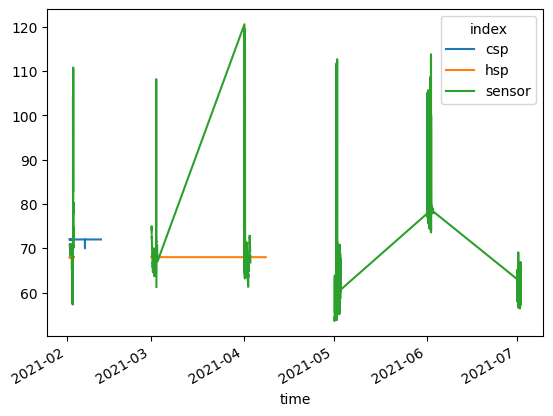

In [218]:
df.plot()